# Show usage of CaltechDATA

In [1]:
#Get metadata from CaltechDATA

import os
from ames.harvesters import get_caltechdata

if os.path.isdir('data') == False:
    os.mkdir('data')
os.chdir('data')

production = True
collection = 'caltechdata.ds'

get_caltechdata(collection,production)

100% (995 of 995) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Gathering data!


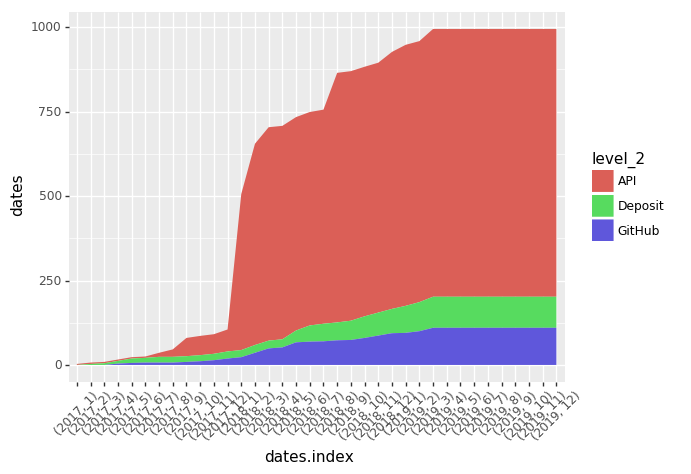

<ggplot: (-9223372029293147227)>

In [2]:
#Collect submissions over time
%matplotlib inline
from ames.harvesters import get_records
import dataset
import pandas as pd
import numpy as np
import plotnine as p9
import warnings
#Plotnine has warning - ignore
warnings.filterwarnings('ignore')

dot_paths = ['._Key','.dates','.resourceType','.subjects','.publicationYear']
keys = dataset.keys(collection)
all_metadata = get_records(dot_paths,'dois',collection,keys)
dates = []
categories = []
for record in all_metadata:
    #Issued date type takes precedence, otherwise Submitted date
    rdate = None
    for date in record['dates']:
        if date['dateType']=='Issued':
            rdate = date['date']
        if date['dateType']=='Submitted':
            if rdate == None:
                rdate = date['date']
    dates.append(rdate)
    #We categorize records based on submission type
    category = 'Deposit'
    if 'subjects' in record:
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                category = 'API'
            if 'Github' in s['subject']:
                category = 'GitHub'
            if 'GitHub' in s['subject']:
                category = 'GitHub'
    #Old records must be from the API
    if int(record['publicationYear']) < 2017:
        category = 'API'
    categories.append(category)
data = {'dates':dates,'categories':categories}
df = pd.DataFrame(data=data)
df = df.astype({'dates':'datetime64'})
#Group by year, month, and category
df = df.groupby([df["dates"].dt.year, df["dates"].dt.month,df['categories']])['dates'].count()
#Fill in categories with 0 if no values that month
df = df.reindex(pd.MultiIndex.from_product([df.index.levels[0],df.index.levels[1],['API','Deposit','GitHub']]),fill_value=0)
#Calculate cumulative sum of categories
df = df.groupby(level=2).cumsum()
#Pull out categories
df = df.reset_index(level=2)


p9.ggplot(df, p9.aes(x='dates.index',y='dates',group='level_2',fill='level_2')) + p9.geom_area() + p9.theme(axis_text_x = p9.element_text(angle=45))